In [3]:
import pandas as pd
import ast
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import matplotlib as plt


# Parameters
CHUNKSIZE = 100000  # Tune this if needed
FILE = "cleaned_file.csv"

# Step 1: Prepare TF-IDF vocabulary on a small sample
sample_df = pd.read_csv(FILE, nrows=50000)

C:\Users\simon\AppData\Local\Temp\ipykernel_21972\3307457746.py:23: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pd.read_csv(FILE, nrows=50000)


In [ ]:
# Saml resultater her
chunks = []

for chunk in pd.read_csv("cleaned_file.csv", chunksize=CHUNKSIZE, low_memory=False):
    if 'content' not in chunk.columns:
        continue

    # Konverter fra string-repræsentation af lister til faktiske lister
    chunk['content'] = chunk['content'].dropna().apply(ast.literal_eval)

    # Fjern 'num' fra hver liste
    chunk['content'] = chunk['content'].apply(lambda tokens: [word for word in tokens if word != "num"])

    chunks.append(chunk)

# Saml alle chunks i én DataFrame
sample_df = pd.concat(chunks, ignore_index=True)

# Gem den opdaterede version uden 'num'
sample_df.to_csv("cleaned_file_without_num.csv", index=False)

In [ ]:
sample_df['content'] = sample_df['content'].apply(ast.literal_eval)
sample_df['text'] = sample_df['content'].apply(lambda x: " ".join(x))

# Filter and label
accepted_types = ['fake', 'bias', 'reliable', 'political']
sample_df = sample_df[sample_df['type'].notna()]
sample_df = sample_df[sample_df['type'].str.lower().isin(accepted_types)]

def map_type(x):
    x = x.lower()
    return 0 if x in ['fake', 'bias', 'conspiracy'] else 1

sample_df['label'] = sample_df['type'].apply(map_type)

# Fit vectorizer on sample
vectorizer = TfidfVectorizer(
    max_features=250000,
    ngram_range=(1, 3),
    min_df=5,
    max_df=0.6
)
vectorizer.fit(sample_df['text'])

# Step 2: Train SVM (SGDClassifier) in chunks
model = SGDClassifier(loss='hinge', max_iter=5)

first_batch = True

reader = pd.read_csv(FILE, chunksize=CHUNKSIZE)
for i, chunk in enumerate(reader):
    print(f"Processing chunk {i + 1}")
    chunk = chunk[chunk['type'].notna()]
    chunk = chunk[chunk['type'].str.lower().isin(accepted_types)]
    chunk['content'] = chunk['content'].apply(ast.literal_eval)
    chunk['text'] = chunk['content'].apply(lambda x: " ".join(x))
    chunk['label'] = chunk['type'].apply(map_type)

    X = vectorizer.transform(chunk['text'])
    y = chunk['label']

    if first_batch:
        model.partial_fit(X, y, classes=np.array([0, 1]))
        first_batch = False
    else:
        model.partial_fit(X, y)

print("✅ Finished training on all chunks")

# Step 3: Final evaluation on a held-out test set
# Sample again for final test
eval_df = pd.read_csv(FILE, skiprows=range(1, 800001), nrows=50000)
eval_df = eval_df[eval_df['type'].notna()]
eval_df = eval_df[eval_df['type'].str.lower().isin(accepted_types)]
eval_df['content'] = eval_df['content'].apply(ast.literal_eval)
eval_df['text'] = eval_df['content'].apply(lambda x: " ".join(x))
eval_df['label'] = eval_df['type'].apply(map_type)

X_test = vectorizer.transform(eval_df['text'])
y_test = eval_df['label']
y_pred = model.predict(X_test)

print("=== Chunkwise SVM Results ===")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred)) 

C:\Users\simon\AppData\Local\Temp\ipykernel_7488\1182800313.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pd.read_csv(FILE, nrows=50000)
C:\Users\simon\AppData\Local\Temp\ipykernel_7488\1182800313.py:45: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 1


C:\Users\simon\AppData\Local\Temp\ipykernel_7488\1182800313.py:45: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 2
Processing chunk 3


C:\Users\simon\AppData\Local\Temp\ipykernel_7488\1182800313.py:45: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 4


C:\Users\simon\AppData\Local\Temp\ipykernel_7488\1182800313.py:45: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 5


C:\Users\simon\AppData\Local\Temp\ipykernel_7488\1182800313.py:45: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 6


C:\Users\simon\AppData\Local\Temp\ipykernel_7488\1182800313.py:45: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 7
Processing chunk 8


C:\Users\simon\AppData\Local\Temp\ipykernel_7488\1182800313.py:45: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 9


C:\Users\simon\AppData\Local\Temp\ipykernel_7488\1182800313.py:45: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 10
✅ Finished training on all chunks


C:\Users\simon\AppData\Local\Temp\ipykernel_7488\1182800313.py:66: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df = pd.read_csv(FILE, skiprows=range(1, 800001), nrows=50000)


=== Chunkwise SVM Results ===
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     15551
           1       0.86      0.92      0.89     21022

    accuracy                           0.87     36573
   macro avg       0.87      0.86      0.86     36573
weighted avg       0.87      0.87      0.87     36573

Accuracy: 0.8686189265305007
Recall: 0.920036152602036
F1 Score: 0.8895072090509808


In [ ]:
import joblib
joblib.dump(model, "advanced_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

<Figure size 600x400 with 0 Axes>

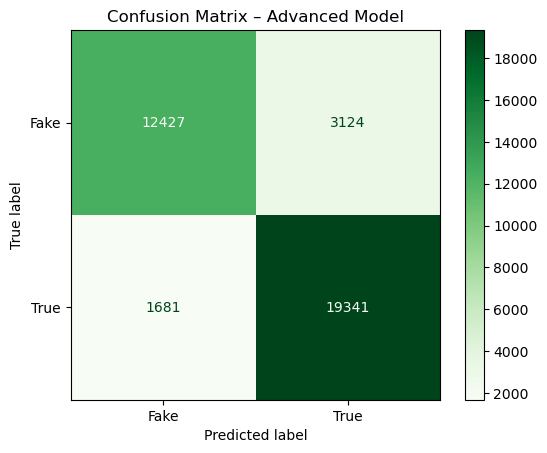

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay
plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Fake", "True"], cmap="Greens")
plt.title("Confusion Matrix – Advanced Model")
plt.show()

In [ ]:
import pandas as pd


liar_df = pd.read_csv("test.tsv", sep='\t', header=None)
liar_df.to_csv("liar_test.csv", index=False)
liar_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [ ]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Setup
file = "liar_test.csv"
chunksize = 10000
true_labels = ["true", "mostly-true"]
fake_labels = ["false", "pants-fire"]
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

# Cleaning function
def clean_text(data):
    if not isinstance(data, str):
        return ""
    data = data.lower()
    data = re.sub(r'\s+', " ", data)
    data = re.sub(r'\d{1,2}[./-]\d{1,2}[./-]\d{2,4}', "<DATE>", data)
    data = re.sub(r'(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec).? \d{1,2},? \d{4}', "<DATE>", data)
    data = re.sub(r'\d{4}-\d{2}-\d{2}', "<DATE>", data)
    data = re.sub(r'[\w._%+-]+@[\w.-]+\.[a-zA-Z]{2,}', "<EMAIL>", data)
    data = re.sub(r'http[s]?://[^\s]+', "<URL>", data)
    data = re.sub(r'\d+(\.\d+)?', "<NUM>", data)
    return data

# Tokenize and stem
def tokenize_and_stem(text):
    tokens = word_tokenize(text)
    return [ps.stem(w) for w in tokens if w.isalpha() and w not in stop_words]

# Process and save
preprocessed_chunks = []

for i, chunk in enumerate(pd.read_csv(file, header=None, chunksize=chunksize, low_memory=False)):
    chunk = chunk[[1, 2]]
    chunk.columns = ["label_liar", "content_liar"]

    chunk = chunk[chunk["label_liar"].isin(true_labels + fake_labels)]
    chunk["label_liar_binary"] = chunk["label_liar"].apply(lambda x: 1 if x in true_labels else 0)

    chunk["content_liar"] = chunk["content_liar"].astype(str).apply(clean_text).apply(tokenize_and_stem)

    preprocessed_chunks.append(chunk)
    print(f"✅ Processed chunk {i + 1}")

# Save final cleaned dataset
final_df = pd.concat(preprocessed_chunks, ignore_index=True)
final_df.to_csv("cleaned_liar_3.csv", index=False)
print("✅ Færdig! Fil gemt som cleaned_liar_2.csv")


✅ Processed chunk 1
✅ Færdig! Fil gemt som cleaned_liar_2.csv


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd
import ast

mylord = "cleaned_liar_3.csv"

# Saml resultater her
chunks = []

for chunk in pd.read_csv(mylord, chunksize=chunksize, low_memory=False):
    if 'content_liar' not in chunk.columns:
        continue

    # Konverter fra string-repræsentation af lister til faktiske lister
    chunk['content_liar'] = chunk['content_liar'].dropna().apply(ast.literal_eval)

    # Fjern 'num' fra hver liste
    chunk['content_liar'] = chunk['content_liar'].apply(lambda tokens: [word for word in tokens if word != "num"])

    chunks.append(chunk)

# Saml alle chunks i én DataFrame
mylord_df = pd.concat(chunks, ignore_index=True)

# Gem den opdaterede version uden 'num'
mylord_df.to_csv("liar_without_num.csv", index=False)


# Bekræft resultat
print("✅ Fjernet 'num' fra content_liar")
print(mylord_df['content_liar'].head())


✅ Fjernet 'num' fra content_liar
0             [build, wall, border, take, liter, year]
1       [wisconsin, pace, doubl, number, layoff, year]
2           [say, john, mccain, done, noth, help, vet]
3    [ask, report, whether, he, center, crimin, sch...
4    [past, five, year, feder, govern, paid, millio...
Name: content_liar, dtype: object


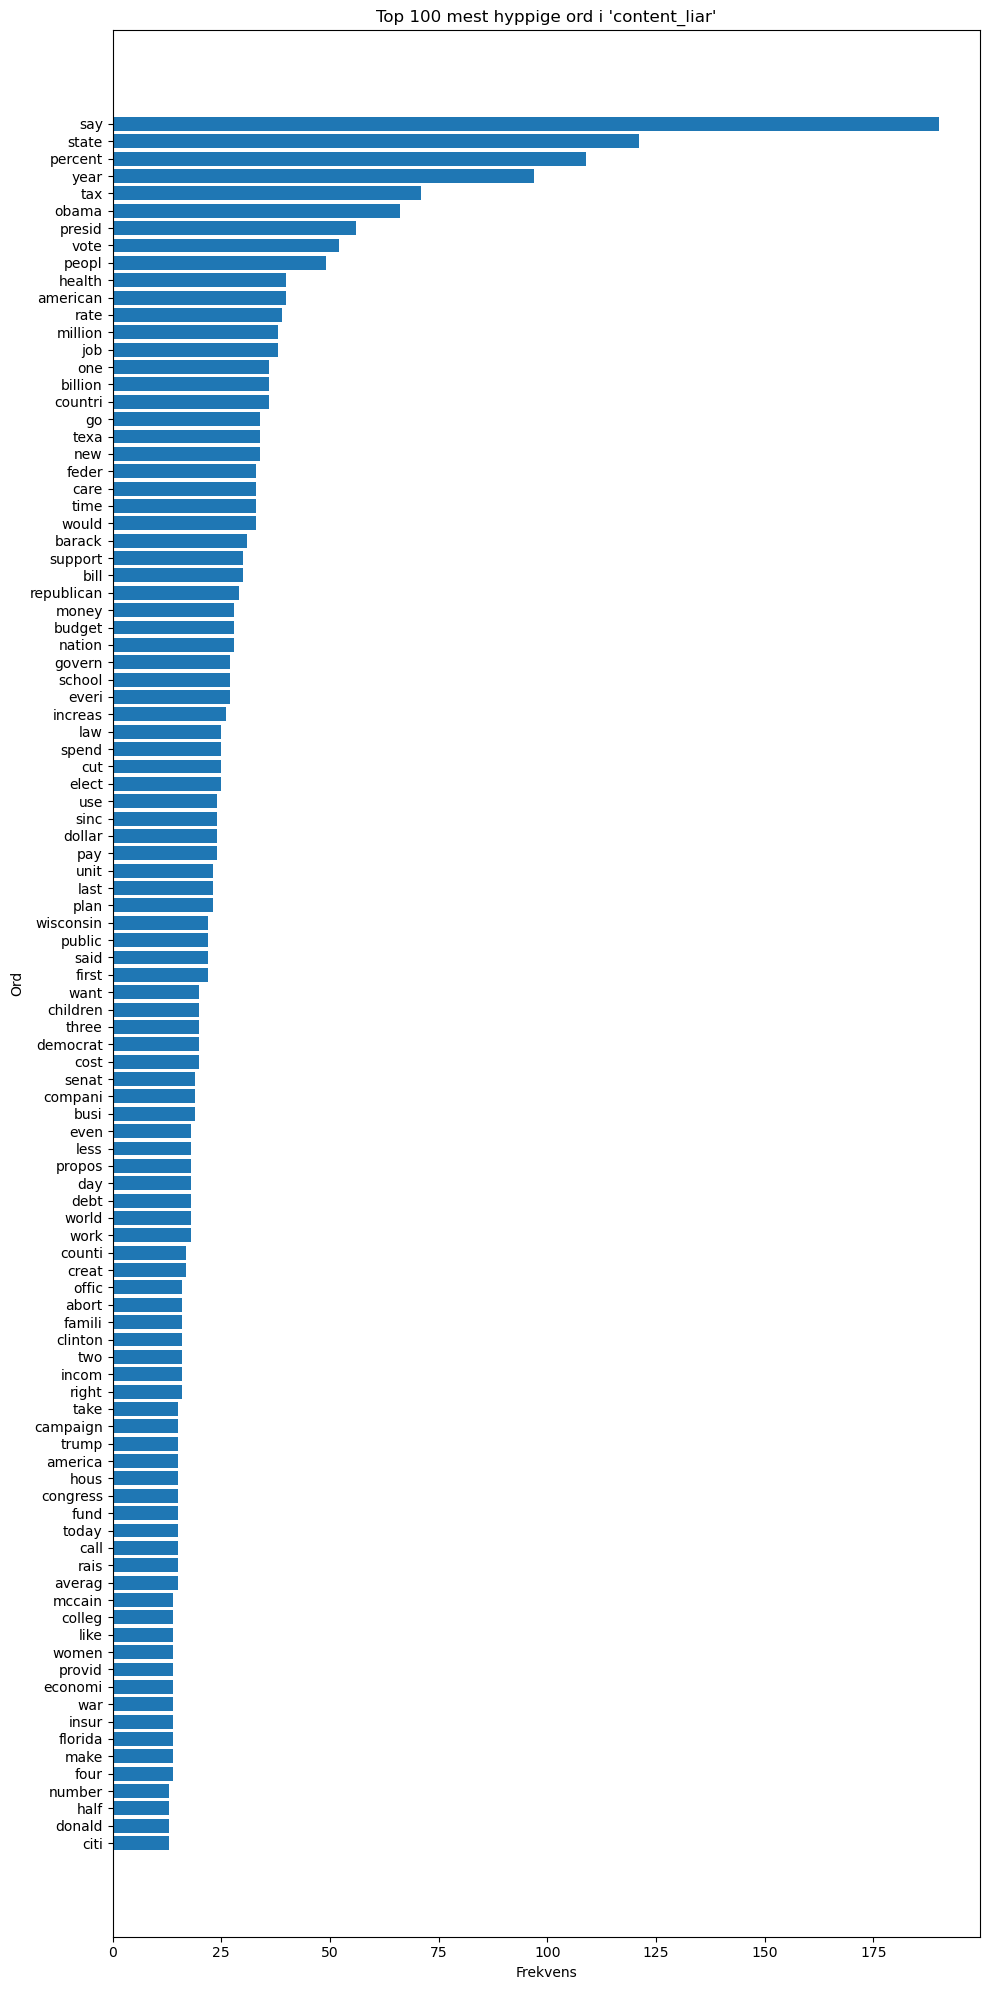

In [ ]:
final_df = pd.read_csv("liar_without_num.csv")
# Plot fordelingen af 'label' (målvariabel)
plt.figure(figsize=(6, 4))
final_df['label_liar_binary'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of target variable 'label_liar_binary'")
plt.xlabel("Label (1 = True, 0 = Fake)")
plt.ylabel("Count")
plt.xticks([0, 1], ["Fake (0)", "True (1)"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot fordelingen af 'type'
plt.figure(figsize=(8, 5))
final_df['label_liar'].value_counts().plot(kind='bar')
plt.title("Distribution of 'label_liar' values")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

chunksize = 10000
liar1_word_counter = Counter()

# Læs tokens og saml frekvenser
for chunk in pd.read_csv("liar_without_num.csv", chunksize=chunksize, low_memory=False):
    if 'content_liar' in chunk.columns:
        # Konverter til faktiske lister (fra string)
        chunk['content_liar'] = chunk['content_liar'].dropna().apply(ast.literal_eval)

        for content in chunk['content_liar']:
            if isinstance(content, list):
                liar1_word_counter.update(content)

# Find de 100 mest hyppige ord
top_100 = liar1_word_counter.most_common(100)

if top_100:
    words, freqs = zip(*top_100)
    
    plt.figure(figsize=(10, 20))
    plt.barh(words, freqs)
    plt.xlabel("Frekvens")
    plt.ylabel("Ord")
    plt.title("Top 100 mest hyppige ord i 'content_liar'")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("❌ Ingen ord fundet – tjek om 'content_liar' er korrekt tokeniseret.")

In [ ]:
model = joblib.load("advanced_model.pkl")       # eller "simple_model.pkl"
vectorizer = joblib.load("vectorizer.pkl")
print(type(model))         # Skal være sklearn.linear_model._stochastic_gradient.SGDClassifier
print(type(vectorizer))    # Skal være sklearn.feature_extraction.text.TfidfVectorizer


In [ ]:
X_liar = vectorizer.transform(final_df['content_liar'])
y_liar = final_df['label_liar_binary']

# 4. Lav predictions
y_pred_liar = model.predict(X_liar)

# 5. Evaluér
print("=== Evaluation on LIAR dataset ===")
print(classification_report(y_liar, y_pred_liar))
print("Accuracy:", accuracy_score(y_liar, y_pred_liar))
print("Recall:", recall_score(y_liar, y_pred_liar))
print("F1 Score:", f1_score(y_liar, y_pred_liar))


=== Evaluation on LIAR dataset ===
              precision    recall  f1-score   support

           0       0.49      0.25      0.33       341
           1       0.59      0.81      0.68       449

    accuracy                           0.57       790
   macro avg       0.54      0.53      0.50       790
weighted avg       0.55      0.57      0.53       790

Accuracy: 0.5658227848101266
Recall: 0.8084632516703786
F1 Score: 0.6791393826005613


<Figure size 600x400 with 0 Axes>

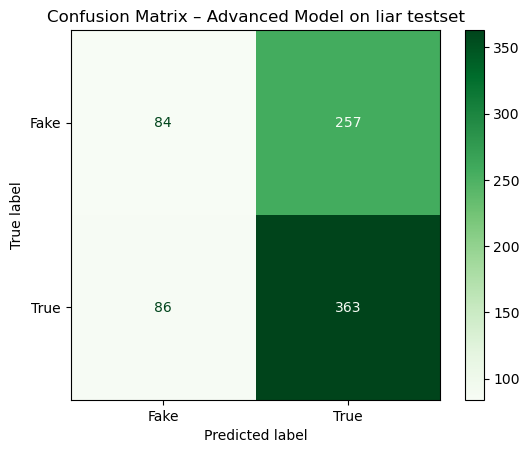

In [ ]:
plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_liar, y_pred_liar, display_labels=["Fake", "True"], cmap="Greens")
plt.title("Confusion Matrix – Advanced Model on liar testset")
plt.show()